# Introduction to Theano - Symbolic math framework

Theano is a software package which allows you to write symbolic code and compile it onto different architectures (in particular, CPU and GPU). It was developed by machine learning researchers at the University of Montreal. Its use is not limited to machine learning applications, but it was designed with machine learning in mind. It's especially good for machine learning techniques which are CPU-intensive and benefit from parallelization (e.g. large neural networks).

For more resources check out:

[Information about Theano](http://deeplearning.net/software/theano/)

[Theano Basics](http://deeplearning.net/software/theano/library/tensor/basic.html)


In [1]:
# import Theano libraries
import theano.tensor as T
from theano import function, scan, grad, shared
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# First simple example - Adding two numbers

## Symbolic variables

In Theano, all algorithms are defined symbolically. It's more like writing out math than writing code. The following Theano variables are symbolic; they don't have an explicit value.

In [2]:
# define symbolic variables
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y

## Functions

To actually compute things with Theano, you define symbolic functions, which can then be called with actual values to retrieve an actual value.

In [3]:
# Now create and compile a function
f = function([x, y], z)

In [4]:
# Now let's use the function
print ('5 + 2 =',f(5,2))

5 + 2 = 7.0


#Adding two matrices

Instead of working with scalars, one can also work directly on vectors or matrices. Just change the type of the symbolic variable

In [5]:
# define the matrix variables
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
# Now create and compile the actual function
f = function([x, y], z)

In [6]:
# Now perform an actual evaluation
print (f([[1, 2], [3, 4]], [[10, 20], [30, 40]]))
print (f([[1, 2], [3, 4]], [[10, 20], [30, 40]]).shape)

[[ 11.  22.]
 [ 33.  44.]]
(2, 2)


# Loops - Compute A**k

Often we need to loop (for or while operation), e.g. looping over data elements in a batch. In Theano this can be done using the 'scan' operator.

In [8]:
k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = function(inputs=[A,k], outputs=final_result, updates=updates)

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [9]:
print (power(range(10),2))
print (power(range(10),4))

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
[  0.00000000e+00   1.00000000e+00   1.60000000e+01   8.10000000e+01
   2.56000000e+02   6.25000000e+02   1.29600000e+03   2.40100000e+03
   4.09600000e+03   6.56100000e+03]


#Shared Variables
Beyond symbolic variables, there are also shared-variables. In contrast to symbolic variables, they actually do have an explicit value, which can be get or set and is shared across functions which use the variable. This allows us to define a function with an internal state. For example, let us say we want to make an accumulator: at the beginning, the state is initialized to zero. Then, on each function call, the state is incremented by the function's argument.

The value of a shared variable can be updated in a function by using the updates argument of theano.function.

In [17]:
# Simple accumulator example, each call to the function 'accumulator' incremeents the shared-variable's value, as defined by the update statement.
state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

In [27]:
# Now let's see the accumulator in action
print (state.get_value())
# Now let's call the accumulator and see what happens
accumulator(1)
print (state.get_value())

9
10


# Computing gradients

A pretty huge benefit of using Theano is its ability to compute gradients. This allows you to symbolically define a function and quickly compute its (numerical) derivative without actually deriving the derivative. This is particular important for deep learning, where gradients are very complex statements. With Theano we don't have to worry. It's just a function call!

Fore more on gradients such as computation on multi-variate functions:

[Theano Gradients](http://deeplearning.net/software/theano/tutorial/gradients.html)

In [28]:
x = T.dscalar('x')
y = x**2
#dy_dx = grad(y,x)
f_x2 = function([x],y)
dy_dx = grad(y,x)
grad_x = function([x], dy_dx)

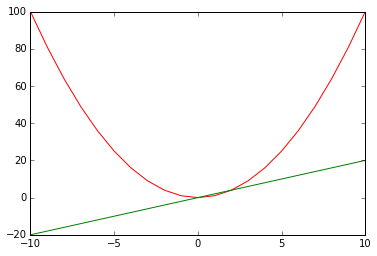

In [29]:
# Now let's plot function and its gradient
x_val=range(-10,11,1)
y_val = [f_x2(i) for i in range(-10,11,1)]
y_grad_x_val = [grad_x(i) for i in range(-10,11,1)]
plt.plot(x_val,y_val,'r-',x_val,y_grad_x_val,'g-')

# Using GPU or CPU

Theano can transparently compile onto different hardware. What device it uses by default depends on your .theanorc file and any environment variables defined, as described in detail here: [Theano configuration](http://deeplearning.net/software/theano/library/config.html). Currently, you should use float32 when using most GPUs, but most people prefer to use float64 on a CPU. For convenience, Theano provides the floatX configuration variable which designates what float accuracy to use. For example, you can run a Python script with certain environment variables set to use the CPU:

THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py

or GPU:

THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py

# Find out if you are using GPU or CPU and configured Theano correctly?

Just run the following script.

In [15]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

[Elemwise{exp,no_inplace}(<TensorType(float64, vector)>)]
Looping 1000 times took 4.749604 seconds
Result is [ 1.23178032  1.61879341  1.52278065 ...,  2.20771815  2.29967753
  1.62323285]
Used the cpu
